In [23]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, accuracy_score, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import pacf

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load data

In [2]:
df = pd.read_csv(
    "../Processed_data/Main_df.csv",
    #index_col=0,           # <— first column becomes the index
    parse_dates=True       # auto–parse that index into datetime
)
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.tail()

,Date,BTC,BTC_Volume,BTC_count,reward,days_since_halving,ETH,ETH_Volume,ETH_count,BCH,...,M2,MSTR,MSTR30,MSTR_Holdings,NVDIA,SP500,day_change,week_change,month_change,6month_change
6309,2025-07-17,119289.842192,7.236384e+10,1.989281e+07,3.125,453.0,3476.784398,4.753285e+10,1.206906e+08,500.064196,...,22020.8,451.339996,9450.0,601550.0,173.000000,6297.359863,0.0,NaN,NaN,NaN
6310,2025-07-18,118003.224496,7.794580e+10,1.989334e+07,3.125,454.0,3549.016245,5.919847e+10,1.207105e+08,514.428382,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6311,2025-07-19,117939.978739,4.756456e+10,1.989535e+07,3.125,455.0,3595.273669,2.603172e+10,1.207110e+08,513.423144,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6312,2025-07-20,117300.785740,5.751545e+10,1.989606e+07,3.125,456.0,3759.471442,4.460045e+10,1.206943e+08,547.876271,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,1.0,NaN,NaN,NaN
6313,2025-07-21,117439.535800,6.982009e+10,1.989339e+07,3.125,457.0,3763.371253,4.261147e+10,1.206961e+08,523.554650,...,22020.8,426.279999,15670.0,607770.0,171.380005,6305.600098,NaN,NaN,NaN,NaN


In [3]:
df1=df[["days_since_halving",'Date','BTC','reward']]
df1['log_BTC'] = np.log(df1['BTC'])
df1=df1.dropna()
df1=df1.reset_index()
df1.head()

C:\Users\deepe\AppData\Local\Temp\ipykernel_26952\573367563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_BTC'] = np.log(df1['BTC'])


,index,days_since_halving,Date,BTC,reward,log_BTC
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137


<Axes: title={'center': 'Log of BTC Price Over Time'}>

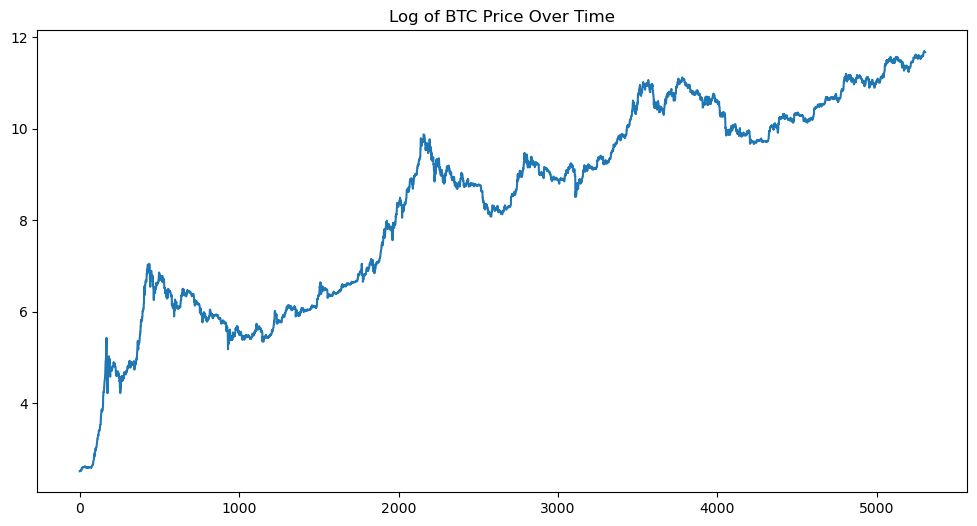

In [4]:
df1['log_BTC'].plot(figsize=(12, 6), title='Log of BTC Price Over Time')

In [5]:
df1["days_total"]=range(len(df1))
df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4


In [6]:
df1['day^2']=df1['days_total']**2
df1['day^3']=df1['days_total']**3
df1['day^4']=df1['days_total']**4

df1["Sin1"]= np.sin(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos1"]= np.cos(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin2"]= np.sin(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos2"]= np.cos(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin3"]= np.sin(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos3"]= np.cos(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin4"]= np.sin(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos4"]= np.cos(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin5"]= np.sin(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos5"]= np.cos(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin6"]= np.sin(6 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos6"]= np.cos(6 * 2 * np.pi * df1["days_since_halving"] / 1439)

df1['SinY1'] = np.sin(2 * np.pi * df1['days_total'] / 365.25)
df1['CosY1'] = np.cos(2 * np.pi * df1['days_total'] / 365.25)
df1['SinY2'] = np.sin(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['CosY2'] = np.cos(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['SinY3'] = np.sin(3 * 2 * np.pi * df1['days_total'] / 365.25) 
df1['CosY3'] = np.cos(3 * 2 * np.pi * df1['days_total'] / 365.25)

df1['day reward'] = df1['days_total'] * df1['reward']
df1['day^2 reward']= df1['day^2'] * df1['reward']

df1['Sin1 reward'] = df1['Sin1'] * df1['reward']
df1['Cos1 reward'] = df1['Cos1'] * df1['reward']
df1['Sin2 reward'] = df1['Sin2'] * df1['reward']
df1['Cos2 reward'] = df1['Cos2'] * df1['reward']
df1['Sin3 reward'] = df1['Sin3'] * df1['reward']
df1['Cos3 reward'] = df1['Cos3'] * df1['reward']
df1['Sin4 reward'] = df1['Sin4'] * df1['reward']
df1['Cos4 reward'] = df1['Cos4'] * df1['reward']

df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total,day^2,day^3,day^4,...,day reward,day^2 reward,Sin1 reward,Cos1 reward,Sin2 reward,Cos2 reward,Sin3 reward,Cos3 reward,Sin4 reward,Cos4 reward
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0,0,0,0,...,0.0,0.0,0.000000,25.000000,0.000000,25.000000,0.000000,25.000000,0.000000,25.000000
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1,1,1,1,...,25.0,25.0,0.000000,25.000000,0.000000,25.000000,0.000000,25.000000,0.000000,25.000000
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2,4,8,16,...,50.0,100.0,0.109159,24.999762,0.218315,24.999047,0.327467,24.997855,0.436613,24.996187
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3,9,27,81,...,75.0,225.0,0.109159,24.999762,0.218315,24.999047,0.327467,24.997855,0.436613,24.996187
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4,16,64,256,...,100.0,400.0,0.218315,24.999047,0.436613,24.996187,0.654878,24.991421,0.873093,24.984750


# Get residues from trend, seasonality model

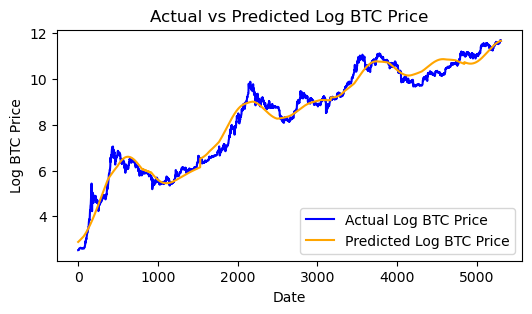

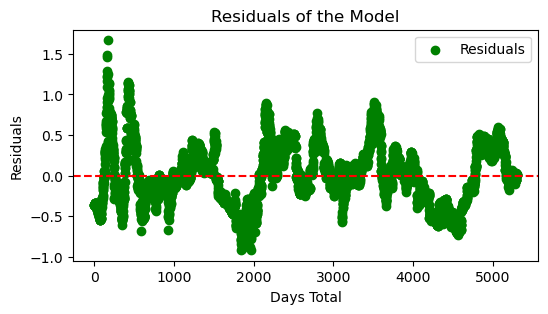

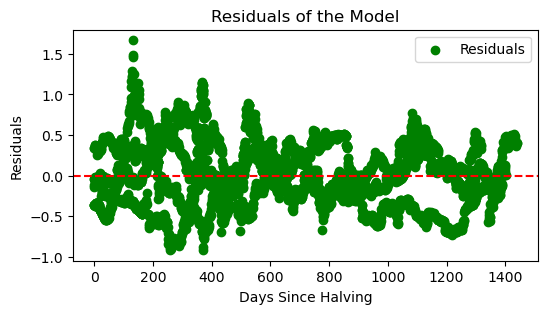

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_BTC   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.230e+04
Date:                Thu, 24 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:21:12   Log-Likelihood:                -2132.6
No. Observations:                5304   AIC:                             4279.
Df Residuals:                    5297   BIC:                             4325.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.6606      0.016    228.346      0.000       3.629       3.692
days_total      0.0025    1.4e-05    177.776      0.000       0.002       0.003
day^2       -2.017e-07   2.53e-09    -79.777      0.000   -2.07e-07   -1.97e-07
Sin1 reward     0.0399      0.000     85.100      0.000       0.039       0.041
Cos1 reward    -0.0246      0.000    -51.588      0.000      -0.026      -0.024
Sin2           -0.3022      0.007    -43.443      0.000      -0.316      -0.289
Cos2           -0.1693      0.007    -23.424      0.000      -0.183      -0.155
==============================================================================
Omnibus:                       64.773   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.971
Skew:                           0.274   Prob(JB):                     2.87e-15
Kurtosis:                       2.945   Cond. No.                     4.06e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
X = df1[["days_total",'day^2', 'Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]
X= sm.add_constant(X)  # Adding a constant term for the intercept

model0=sm.OLS(y, X).fit()
y_pred = model0.predict(X)

plt.figure(figsize=(6, 3))
plt.plot(df1['days_total'], y, label='Actual Log BTC Price', color='blue')
plt.plot(df1['days_total'], y_pred, label='Predicted Log BTC Price', color='orange')
plt.title('Actual vs Predicted Log BTC Price')
plt.xlabel('Date')
plt.ylabel('Log BTC Price')
plt.legend()
plt.show()

residues = y - y_pred
plt.figure(figsize=(6, 3))
plt.scatter(df1['days_total'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Total')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df1['days_since_halving'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Since Halving')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


model0.summary()

# check for autocorrelation

<Axes: title={'center': 'Residuals of Model-0'}>

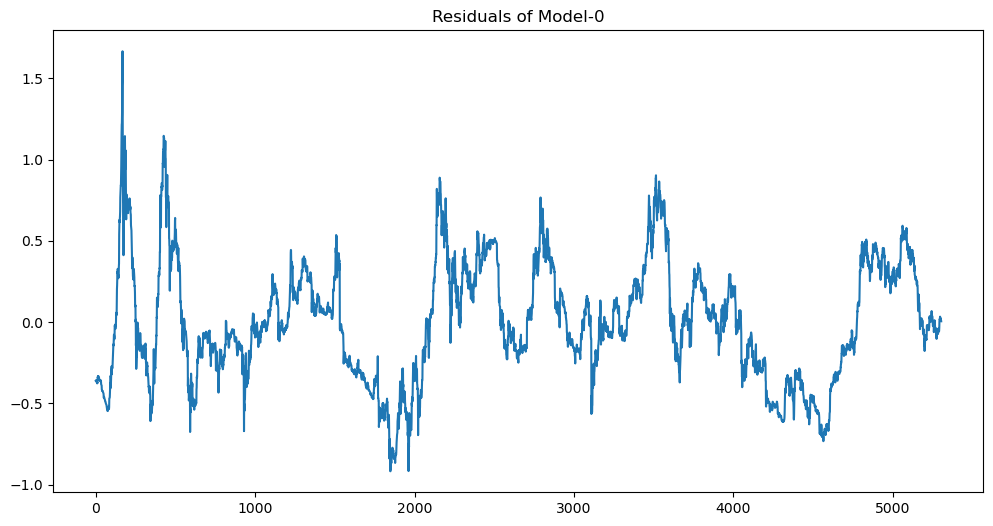

In [15]:
residues.plot(figsize=(12, 6), title='Residuals of Model-0')

<Figure size 1200x400 with 0 Axes>

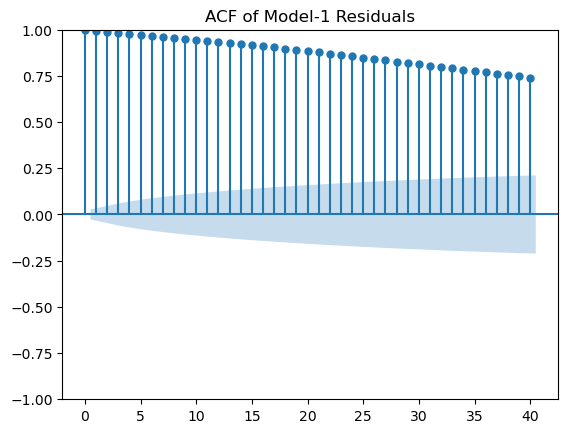

<Figure size 1200x400 with 0 Axes>

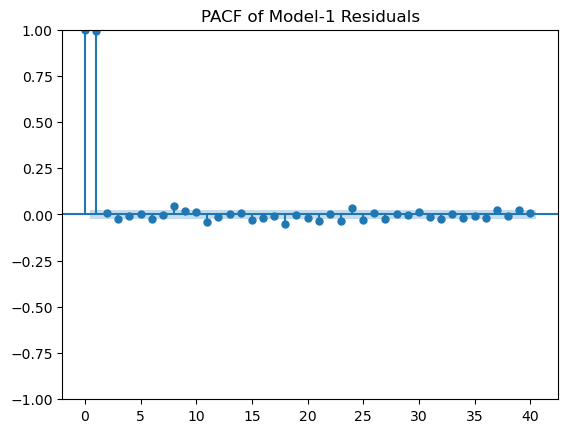

PACF values:
  lag 1: 0.9945
  lag 2: 0.0066
  lag 3: -0.0250


In [25]:
plt.figure(figsize=(12,4))
plot_acf(residues, lags=40, alpha=0.05)
plt.title("ACF of Model-1 Residuals")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(residues, lags=40, alpha=0.05)
plt.title("PACF of Model-1 Residuals")
plt.show()

# 2) Compute PACF values up to lag 3 using a supported method
pacf_vals = pacf(residues, nlags=3, method='yw')

print("PACF values:")
for lag in (1, 2, 3):
    print(f"  lag {lag}: {pacf_vals[lag]:.4f}")

In [26]:
arma_resid = ARIMA(residues, order=(1,0,0)).fit()
print(arma_resid.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5304
Model:                 ARIMA(1, 0, 0)   Log Likelihood                9807.433
Date:                Thu, 24 Jul 2025   AIC                         -19608.866
Time:                        14:55:39   BIC                         -19589.137
Sample:                             0   HQIC                        -19601.972
                               - 5304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.592e-12      0.096  -5.84e-11      1.000      -0.188       0.188
ar.L1          0.9944      0.001    946.744      0.000       0.992       0.996
sigma2         0.0014   8.78e-06    165.029      0.0

# Testing AR(1) model

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3511, test RMSE: 0.4278


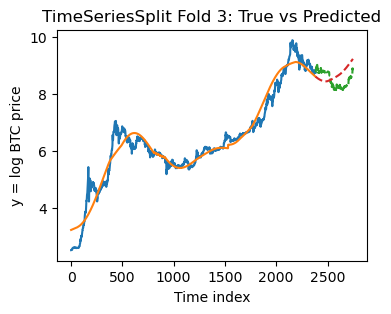

2749 365
Fold 4 → train RMSE: 0.3516, test RMSE: 0.5360


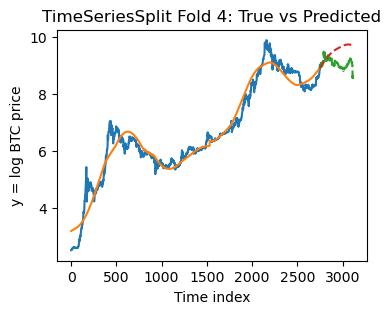

3114 365
Fold 5 → train RMSE: 0.3517, test RMSE: 0.2163


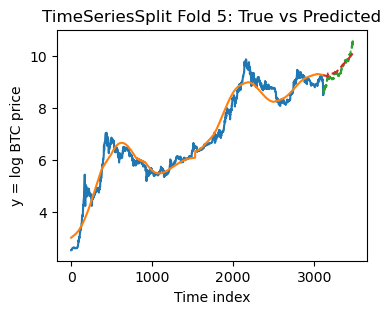

3479 365
Fold 6 → train RMSE: 0.3389, test RMSE: 0.4102


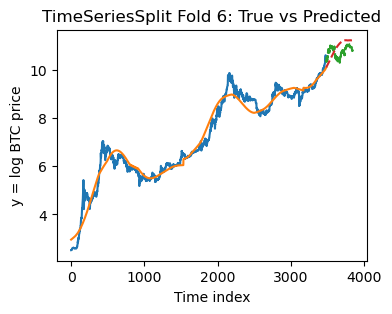

3844 365
Fold 7 → train RMSE: 0.3419, test RMSE: 0.4846


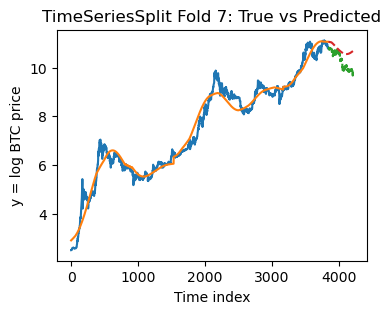

4209 365
Fold 8 → train RMSE: 0.3410, test RMSE: 0.7605


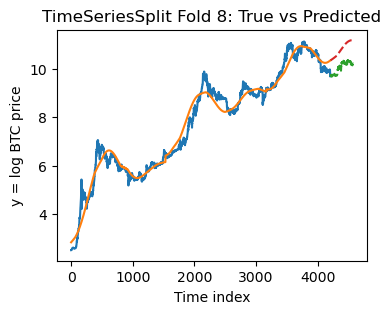

4574 365
Fold 9 → train RMSE: 0.3549, test RMSE: 0.5015


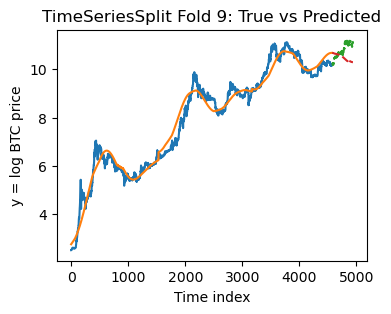

4939 365
Fold 10 → train RMSE: 0.3617, test RMSE: 0.4688


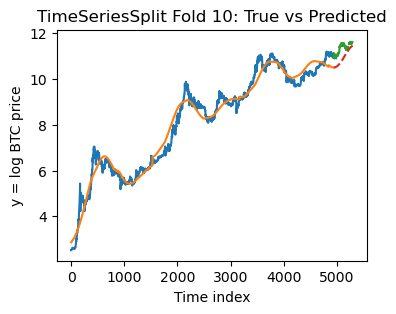

Average Train RMSE: 0.34908407133901553
Average Test RMSE: 0.4757168034747728


In [27]:
X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
Fold 3 → OLS Train RMSE: 0.3511, OLS Test RMSE: 0.4278, OLS+AR1 Test RMSE: 0.4177


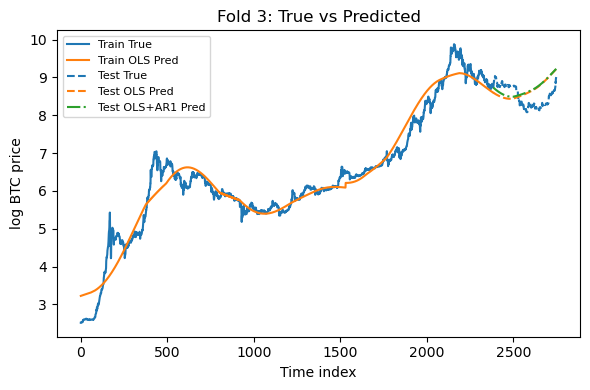

Fold 4 → OLS Train RMSE: 0.3516, OLS Test RMSE: 0.5360, OLS+AR1 Test RMSE: 0.5474


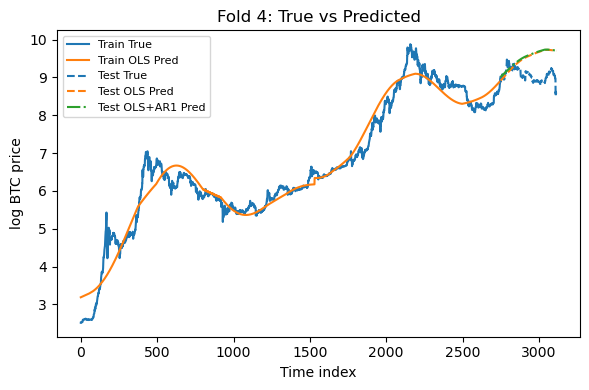

Fold 5 → OLS Train RMSE: 0.3517, OLS Test RMSE: 0.2163, OLS+AR1 Test RMSE: 5.2651


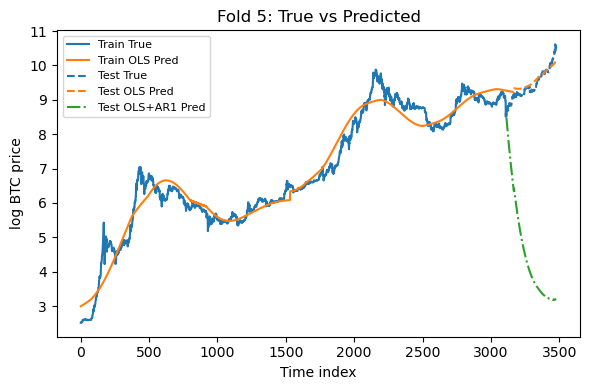

Fold 6 → OLS Train RMSE: 0.3389, OLS Test RMSE: 0.4102, OLS+AR1 Test RMSE: 0.4221


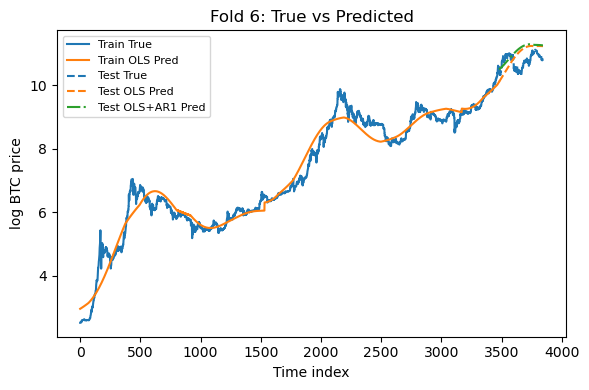

Fold 7 → OLS Train RMSE: 0.3419, OLS Test RMSE: 0.4846, OLS+AR1 Test RMSE: 0.4302


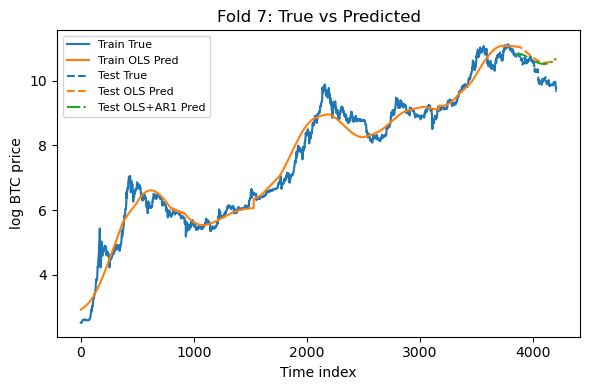

Fold 8 → OLS Train RMSE: 0.3410, OLS Test RMSE: 0.7605, OLS+AR1 Test RMSE: 0.5861


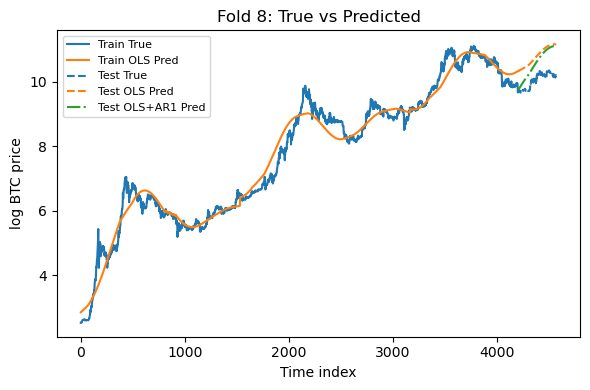

Fold 9 → OLS Train RMSE: 0.3549, OLS Test RMSE: 0.5015, OLS+AR1 Test RMSE: 0.5586


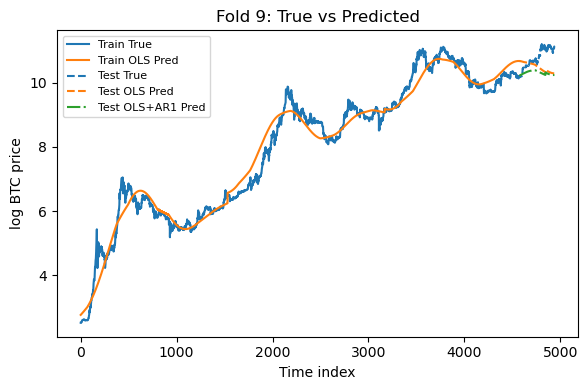

Fold 10 → OLS Train RMSE: 0.3617, OLS Test RMSE: 0.4688, OLS+AR1 Test RMSE: 0.2324


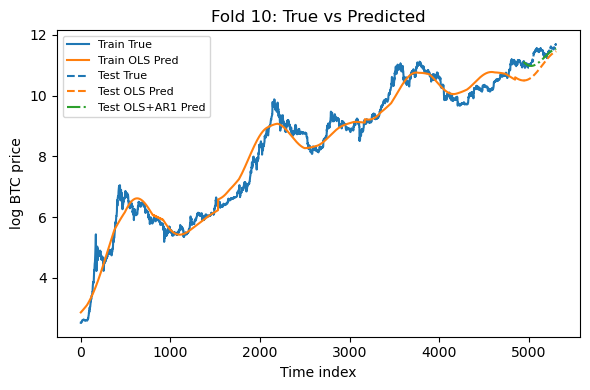

Average Train RMSE (OLS): 0.34908407133901553
Average Test RMSE  (OLS): 0.4757168034747728
Average Test RMSE  (OLS+AR1): 1.0574656667713356


In [30]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y = df1["log_BTC"]
X = sm.add_constant(X)

train_rmse_list = []
test_rmse_list  = []
test_rmse_ar1_list = []

tscv = TimeSeriesSplit(n_splits=10, test_size=365, gap=0)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:
        print(f"Fold {fold} skipped: not enough training data.")
        continue

    # 1) Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 2) Fit OLS trend+seasonality
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # 3) Fit AR(1) on the in-sample residuals
    resid_train = y_train - y_train_pred
    ar1_model = ARIMA(resid_train, order=(1,0,0)).fit()
    phi  = ar1_model.params.get("ar.L1", 0.0)
    c0   = ar1_model.params.get("const", 0.0)

    # 4) Forecast residuals over the test block
    #    r_hat[0] = c0 + phi * resid_train.iloc[-1]
    #    r_hat[h] = c0 + phi * r_hat[h-1] thereafter
    n_test = len(test_idx)
    r_hat = np.empty(n_test)
    last_resid = resid_train.iloc[-1]
    for h in range(n_test):
        if h == 0:
            r_hat[h] = c0 + phi * last_resid
        else:
            r_hat[h] = c0 + phi * r_hat[h-1]

    # 5) Combine: OLS forecast + AR(1)-residual forecast
    y_test_pred_ar1 = y_test_pred + r_hat

    # 6) Compute RMSEs
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test, y_test_pred)
    test_rmse_ar1 = root_mean_squared_error(y_test, y_test_pred_ar1)

    print(f"Fold {fold} → "
          f"OLS Train RMSE: {train_rmse:.4f}, "
          f"OLS Test RMSE: {test_rmse:.4f}, "
          f"OLS+AR1 Test RMSE: {test_rmse_ar1:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    test_rmse_ar1_list.append(test_rmse_ar1)

    # 7) Plot true vs. predicted (OLS vs OLS+AR1)
    plt.figure(figsize=(6,4))
    # in-sample
    plt.plot(train_idx, y_train,      label="Train True",    color="C0")
    plt.plot(train_idx, y_train_pred, label="Train OLS Pred",color="C1")
    # out-of-sample
    plt.plot(test_idx, y_test,        '--', label="Test True",       color="C0")
    plt.plot(test_idx, y_test_pred,   '--', label="Test OLS Pred",   color="C1")
    plt.plot(test_idx, y_test_pred_ar1,'-.',label="Test OLS+AR1 Pred",color="C2")

    plt.legend(loc="upper left", fontsize=8)
    plt.title(f"Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("log BTC price")
    plt.tight_layout()
    plt.show()

print("Average Train RMSE (OLS):", np.mean(train_rmse_list))
print("Average Test RMSE  (OLS):", np.mean(test_rmse_list))
print("Average Test RMSE  (OLS+AR1):", np.mean(test_rmse_ar1_list))


## 1 day ahead

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.ar_model import AutoReg
import warnings

# suppress harmless warnings
warnings.filterwarnings("ignore", category=UserWarning)

Days = 1
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

y_true      = []
y_pred_base = []
y_pred_ar1  = []

min_train = 365*6
n = len(data)

for t in range(min_train, n - Days):
    if t % 500 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # --- 1) Train linear trend+season model ---
    train = data.iloc[: t+1]
    X_train = train[["days_total","day^2","Sin1 reward","Cos1 reward","Sin2","Cos2"]]
    y_train = train["log_BTC"]

    lr = LinearRegression().fit(X_train, y_train)

    # --- 2) Base predictions ---
    X_t   = data.iloc[[t]][X_train.columns]
    X_t1  = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_t1_hat_base = lr.predict(X_t1)[0]

    # --- 3) Fit AR(1) on residuals via AutoReg ---
    resid = y_train - lr.predict(X_train)
    # Note: AutoReg by default includes a constant
    ar1 = AutoReg(resid, lags=1, old_names=False).fit()
    c0, phi = ar1.params.iloc[0], ar1.params.iloc[1]

    # --- 4) Forecast residuals for t+1 and t+2 (since Days=1) ---
    last_r    = resid.iloc[-1]
    r_hat_t   = c0 + phi * last_r
    r_hat_t1  = c0 + phi * r_hat_t

    # --- 5) Corrected predictions ---
    y_t_hat_ar1  = y_t_hat_base  + r_hat_t
    y_t1_hat_ar1 = y_t1_hat_base + r_hat_t1

    # --- 6) Record true & predicted directions ---
    y_true.append(int(data.iloc[t]["Delta_true"]))
    y_pred_base.append(1 if (y_t1_hat_base  > y_t_hat_base)  else 0)
    y_pred_ar1.append( 1 if (y_t1_hat_ar1 > y_t_hat_ar1) else 0)

# Baselines
always1_acc = np.mean(y_true)
always0_acc = 1 - always1_acc
yt = np.array(y_true)
lag_acc     = accuracy_score(yt[1:], yt[:-1])
opp_lag_acc = 1 - lag_acc

print("\nBaselines:")
print(f"  Always UP (1):        {always1_acc:.3%}")
print(f"  Always DOWN (0):      {always0_acc:.3%}")
print(f"  Same as yesterday:    {lag_acc:.3%}")
print(f"  Opposite of yesterday:{opp_lag_acc:.3%}")

# Evaluate
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)


Predicting directional change 1-days in the future
Processing time index 5000 / 5303
Baselines:
  Always UP (1):        45.519%
  Always DOWN (0):      54.481%
  Same as yesterday:    47.558%
  Opposite of yesterday:52.442%

Directional Accuracy (base OLS):      44.555%
Confusion Matrix (base) (rows=true, cols=pred):
[[ 523 1173]
 [ 553  864]]

Directional Accuracy (OLS + AR(1)):  46.226%
Confusion Matrix (corrected) (rows=true, cols=pred):
[[ 472 1224]
 [ 450  967]]


## 7 days ahead

In [35]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Days = 7   # ← try 1, 7, 30, 180, etc.
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

y_true      = []
y_pred_base = []
y_pred_ar1  = []

min_train = 365 * 6
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[["days_total","day^2",
                     "Sin1 reward","Cos1 reward",
                     "Sin2","Cos2"]]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Base log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][X_train.columns]
    X_td  = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_td_hat_base = lr.predict(X_td)[0]

    # 3) Fit AR(1) on in-sample residuals via AutoReg
    resid = y_train - lr.predict(X_train)
    ar1   = AutoReg(resid, lags=1, old_names=False).fit()
    c0, phi = ar1.params.iloc[0], ar1.params.iloc[1]

    # 4) Build residual-forecast array of length Days+1
    #    r_hat[0] is 1-step ahead from the last *observed* residual
    last_r = resid.iloc[-1]
    r_hat  = np.empty(Days+1)
    r_hat[0] = c0 + phi * last_r
    for h in range(1, Days+1):
        r_hat[h] = c0 + phi * r_hat[h-1]

    # 5) Correct both forecasts
    #    “horizon 0” correction for y_t, and “horizon Days” for y_{t+Days}
    y_t_hat_ar1  = y_t_hat_base  + r_hat[0]
    y_td_hat_ar1 = y_td_hat_base + r_hat[Days]

    # 6) Record
    y_true.append(int(data.iloc[t]["Delta_true"]))
    y_pred_base.append(1 if y_td_hat_base  > y_t_hat_base  else 0)
    y_pred_ar1.append( 1 if y_td_hat_ar1 > y_t_hat_ar1 else 0)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

# Evaluation
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)


Predicting directional change 7-days in the future
Processing time index 5000 / 5303
Baselines:
  Always predict UP (1):        52.333%
  Always predict DOWN (0):      47.667%
  Predict same as past:    48.903%
  Predict opposite of past:51.097%

Directional Accuracy (base OLS):      51.143%
Confusion Matrix (base) (rows=true, cols=pred):
[[ 553  928]
 [ 590 1036]]

Directional Accuracy (OLS + AR(1)):  53.814%
Confusion Matrix (corrected) (rows=true, cols=pred):
[[ 449 1032]
 [ 403 1223]]


## 30 days ahead

In [36]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Days = 30   # ← try 1, 7, 30, 180, etc.
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

y_true      = []
y_pred_base = []
y_pred_ar1  = []

min_train = 365 * 6
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[["days_total","day^2",
                     "Sin1 reward","Cos1 reward",
                     "Sin2","Cos2"]]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Base log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][X_train.columns]
    X_td  = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_td_hat_base = lr.predict(X_td)[0]

    # 3) Fit AR(1) on in-sample residuals via AutoReg
    resid = y_train - lr.predict(X_train)
    ar1   = AutoReg(resid, lags=1, old_names=False).fit()
    c0, phi = ar1.params.iloc[0], ar1.params.iloc[1]

    # 4) Build residual-forecast array of length Days+1
    #    r_hat[0] is 1-step ahead from the last *observed* residual
    last_r = resid.iloc[-1]
    r_hat  = np.empty(Days+1)
    r_hat[0] = c0 + phi * last_r
    for h in range(1, Days+1):
        r_hat[h] = c0 + phi * r_hat[h-1]

    # 5) Correct both forecasts
    #    “horizon 0” correction for y_t, and “horizon Days” for y_{t+Days}
    y_t_hat_ar1  = y_t_hat_base  + r_hat[0]
    y_td_hat_ar1 = y_td_hat_base + r_hat[Days]

    # 6) Record
    y_true.append(int(data.iloc[t]["Delta_true"]))
    y_pred_base.append(1 if y_td_hat_base  > y_t_hat_base  else 0)
    y_pred_ar1.append( 1 if y_td_hat_ar1 > y_t_hat_ar1 else 0)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

# Evaluation
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)

Predicting directional change 30-days in the future
Processing time index 5200 / 5303
Baselines:
  Always predict UP (1):        53.956%
  Always predict DOWN (0):      46.044%
  Predict same as past:    50.589%
  Predict opposite of past:49.411%

Directional Accuracy (base OLS):      53.470%
Confusion Matrix (base) (rows=true, cols=pred):
[[ 539  881]
 [ 554 1110]]

Directional Accuracy (OLS + AR(1)):  57.134%
Confusion Matrix (corrected) (rows=true, cols=pred):
[[ 473  947]
 [ 375 1289]]


## 90 days ahead

In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Days = 90   # ← try 1, 7, 30, 180, etc.
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

y_true      = []
y_pred_base = []
y_pred_ar1  = []

min_train = 365 * 6
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[["days_total","day^2",
                     "Sin1 reward","Cos1 reward",
                     "Sin2","Cos2"]]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Base log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][X_train.columns]
    X_td  = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_td_hat_base = lr.predict(X_td)[0]

    # 3) Fit AR(1) on in-sample residuals via AutoReg
    resid = y_train - lr.predict(X_train)
    ar1   = AutoReg(resid, lags=1, old_names=False).fit()
    c0, phi = ar1.params.iloc[0], ar1.params.iloc[1]

    # 4) Build residual-forecast array of length Days+1
    #    r_hat[0] is 1-step ahead from the last *observed* residual
    last_r = resid.iloc[-1]
    r_hat  = np.empty(Days+1)
    r_hat[0] = c0 + phi * last_r
    for h in range(1, Days+1):
        r_hat[h] = c0 + phi * r_hat[h-1]

    # 5) Correct both forecasts
    #    “horizon 0” correction for y_t, and “horizon Days” for y_{t+Days}
    y_t_hat_ar1  = y_t_hat_base  + r_hat[0]
    y_td_hat_ar1 = y_td_hat_base + r_hat[Days]

    # 6) Record
    y_true.append(int(data.iloc[t]["Delta_true"]))
    y_pred_base.append(1 if y_td_hat_base  > y_t_hat_base  else 0)
    y_pred_ar1.append( 1 if y_td_hat_ar1 > y_t_hat_ar1 else 0)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

# Evaluation
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)

Predicting directional change 90-days in the future
Processing time index 5200 / 5303
Baselines:
  Always predict UP (1):        55.357%
  Always predict DOWN (0):      44.643%
  Predict same as past:    57.055%
  Predict opposite of past:42.945%

Directional Accuracy (base OLS):      63.261%
Confusion Matrix (base) (rows=true, cols=pred):
[[ 633  717]
 [ 394 1280]]

Directional Accuracy (OLS + AR(1)):  61.243%
Confusion Matrix (corrected) (rows=true, cols=pred):
[[ 502  848]
 [ 324 1350]]


## 180 days ahead

In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Days = 180   # ← try 1, 7, 30, 180, etc.
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

y_true      = []
y_pred_base = []
y_pred_ar1  = []

min_train = 365 * 6
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # 1) Fit OLS trend+seasonality on [0…t]
    train = data.iloc[: t+1]
    X_train = train[["days_total","day^2",
                     "Sin1 reward","Cos1 reward",
                     "Sin2","Cos2"]]
    y_train = train["log_BTC"]
    lr = LinearRegression().fit(X_train, y_train)

    # 2) Base log-price predictions at t and t+Days
    X_t   = data.iloc[[t]][X_train.columns]
    X_td  = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_td_hat_base = lr.predict(X_td)[0]

    # 3) Fit AR(1) on in-sample residuals via AutoReg
    resid = y_train - lr.predict(X_train)
    ar1   = AutoReg(resid, lags=1, old_names=False).fit()
    c0, phi = ar1.params.iloc[0], ar1.params.iloc[1]

    # 4) Build residual-forecast array of length Days+1
    #    r_hat[0] is 1-step ahead from the last *observed* residual
    last_r = resid.iloc[-1]
    r_hat  = np.empty(Days+1)
    r_hat[0] = c0 + phi * last_r
    for h in range(1, Days+1):
        r_hat[h] = c0 + phi * r_hat[h-1]

    # 5) Correct both forecasts
    #    “horizon 0” correction for y_t, and “horizon Days” for y_{t+Days}
    y_t_hat_ar1  = y_t_hat_base  + r_hat[0]
    y_td_hat_ar1 = y_td_hat_base + r_hat[Days]

    # 6) Record
    y_true.append(int(data.iloc[t]["Delta_true"]))
    y_pred_base.append(1 if y_td_hat_base  > y_t_hat_base  else 0)
    y_pred_ar1.append( 1 if y_td_hat_ar1 > y_t_hat_ar1 else 0)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")

# Evaluation
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)

Predicting directional change 180-days in the future
Processing time index 5100 / 5303
Baselines:
  Always predict UP (1):        62.100%
  Always predict DOWN (0):      37.900%
  Predict same as past:    61.365%
  Predict opposite of past:38.635%

Directional Accuracy (base OLS):      70.450%
Confusion Matrix (base) (rows=true, cols=pred):
[[ 554  558]
 [ 309 1513]]

Directional Accuracy (OLS + AR(1)):  71.132%
Confusion Matrix (corrected) (rows=true, cols=pred):
[[ 533  579]
 [ 268 1554]]


# Other

In [31]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA

Days = 1
print(f"Predicting directional change {Days}-days in the future")

data = df1.copy()
data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"], 1, 0
)

# containers
y_true        = []
y_pred_base   = []   # original linear‐model predictions
y_pred_ar1    = []   # OLS+AR1 corrected predictions

min_train = 365*6
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}", end="\r")

    # --- train on rows [0…t] ---
    train = data.iloc[:t+1]
    X_train = train[["days_total","day^2","Sin1 reward","Cos1 reward","Sin2","Cos2"]]
    y_train = train["log_BTC"]

    # 1) fit OLS trend+seasonality
    lr = LinearRegression().fit(X_train, y_train)

    # 2) predict log-price at t and t+Days (base)
    X_t  = data.iloc[[t]][X_train.columns]
    X_t1 = data.iloc[[t+Days]][X_train.columns]
    y_t_hat_base  = lr.predict(X_t)[0]
    y_t1_hat_base = lr.predict(X_t1)[0]

    # 3) fit AR(1) on in-sample residuals
    resid = y_train - lr.predict(X_train)
    ar1 = ARIMA(resid, order=(1,0,0)).fit()
    phi = ar1.params.get("ar.L1", 0.0)
    c0  = ar1.params.get("const", 0.0)

    # 4) forecast residuals for t and t+Days
    last_r = resid.iloc[-1]
    # one-step ahead residual forecast for point t+1 relative to training end
    r_hat_t  = c0 + phi * last_r
    # two-step ahead (i.e. Days=1) residual forecast
    r_hat_t1 = c0 + phi * r_hat_t

    # 5) corrected log-price forecasts
    y_t_hat_ar1  = y_t_hat_base  + r_hat_t
    y_t1_hat_ar1 = y_t1_hat_base + r_hat_t1

    # 6) record true & predicted directions
    y_true.append(int(data.iloc[t]["Delta_true"]))
    # base directional pred (for comparison)
    y_pred_base.append(1 if (y_t1_hat_base > y_t_hat_base) else 0)
    # AR1-corrected directional pred
    y_pred_ar1.append(1 if (y_t1_hat_ar1 > y_t_hat_ar1) else 0)

# --- compute baselines on y_true & y_pred_base ---
always1_acc = np.mean(y_true)
always0_acc = 1 - always1_acc
yt = np.array(y_true)
lag_acc     = accuracy_score(yt[1:], yt[:-1])
opp_lag_acc = 1 - lag_acc

print("\nBaselines:")
print(f"  Always UP (1):        {always1_acc:.3%}")
print(f"  Always DOWN (0):      {always0_acc:.3%}")
print(f"  Same as yesterday:    {lag_acc:.3%}")
print(f"  Opposite of yesterday:{opp_lag_acc:.3%}")

# --- evaluate both models ---
acc_base = accuracy_score(y_true, y_pred_base)
acc_ar1  = accuracy_score(y_true, y_pred_ar1)
cm_base  = confusion_matrix(y_true, y_pred_base)
cm_ar1   = confusion_matrix(y_true, y_pred_ar1)

print(f"\nDirectional Accuracy (base OLS):      {acc_base:.3%}")
print("Confusion Matrix (base) (rows=true, cols=pred):")
print(cm_base)

print(f"\nDirectional Accuracy (OLS + AR(1)):  {acc_ar1:.3%}")
print("Confusion Matrix (corrected) (rows=true, cols=pred):")
print(cm_ar1)


Predicting directional change 1-days in the future


c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users

c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users

c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users

c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users

c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\deepe\anaconda3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users

KeyboardInterrupt: 

In [ ]:
# assume y is your full series of length N
N = len(y)

# storage
y_trend_pred = np.zeros(N)
y_full_pred  = np.zeros(N)
residuals    = []

# choose a minimum train size before you start forecasting
min_train = 50  

for t in range(min_train, N):
    # 1) Fit your trend+seasonality model on y[:t]
    #    (replace this with your actual code)
    model1 = fit_trend_seasonality(y[:t])  
    y_trend_pred[t] = model1.forecast()[0]       
    
    # 2) If we have at least one past residual, forecast it with AR(1)
    if t > min_train:
        # fit AR(1) on residuals[0:t-1]
        ar1 = ARIMA(residuals, order=(1,0,0)).fit(disp=False)
        phi = ar1.params['ar.L1']
        # last observed residual:
        last_r = residuals[-1]
        # one‐step AR(1) forecast
        r_pred = phi * last_r
    else:
        # for the very first step, just assume zero
        r_pred = 0.0

    # 3) combine trend+AR(1) residual forecast
    y_full_pred[t] = y_trend_pred[t] + r_pred

    # 4) now observe the true y[t] and record its residual
    residuals.append(y[t] - y_trend_pred[t])

# at this point: 
#   y_trend_pred holds your old forecasts,
#   y_full_pred  holds the new, AR‐corrected forecasts,
#   residuals    holds the in‐sample residual history.
